In [9]:
from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel
from Classes.LinearSolver import solve


import numpy as np
from numpy.linalg import norm

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        
        trans = (self._rho*self._cp*self._grid.vol)*((self._T[1:-1] - self._Told[1:-1])/self._dt)
        
        # Calculate the linearization coefficient
        
        coeffPt = (self._rho*self._cp*self._grid.vol)/self._dt
        
        # Add to coefficient arrays
        
        coeffs.accumulate_aP(coeffPt)
        coeffs.accumulate_rP(trans)

        return coeffs


# Define the grid
lx = 1.0
ly = 0.1
lz = 0.1
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 100
dt = 0.1
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 10
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 1000
k = 100

# Define convection parameters
ho = 25
To = 200

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 400, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
# Note: If there are a lot of timesteps, this will cost a
#       lot of memory. It is suggested to set a parameter to 
#       only store the solution every N timesteps.
T_solns = [np.copy(T)]



# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    # Note: do not use copy here because that creates a new object
    #       and we want the reference in the transient model to remain
    #       valid
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))




Timestep = 0; Time = 0.1
Iteration = 0; Max. Resid. = 1900.0000000000005; Avg. Resid. = 280.00000000000006
Iteration = 1; Max. Resid. = 1.8269474821863696e-10; Avg. Resid. = 1.1564225133042783e-10
Timestep = 1; Time = 0.2
Iteration = 0; Max. Resid. = 1894.0305052764638; Avg. Resid. = 279.1948682796256
Iteration = 1; Max. Resid. = 2.5642066248110496e-10; Avg. Resid. = 9.214318197336979e-11
Timestep = 2; Time = 0.30000000000000004
Iteration = 0; Max. Resid. = 1888.0814423771951; Avg. Resid. = 278.39259435765905
Iteration = 1; Max. Resid. = 2.800106813083403e-10; Avg. Resid. = 1.951775630004704e-10
Timestep = 3; Time = 0.4
Iteration = 0; Max. Resid. = 1882.1527381203266; Avg. Resid. = 277.5931677918926
Iteration = 1; Max. Resid. = 2.6125235308427364e-10; Avg. Resid. = 1.8886368025050615e-10
Timestep = 4; Time = 0.5
Iteration = 0; Max. Resid. = 1876.2443195933029; Avg. Resid. = 276.79657817898044
Iteration = 1; Max. Resid. = 2.7966962079517543e-10; Avg. Resid. = 1.0662262184268911e-10
Time

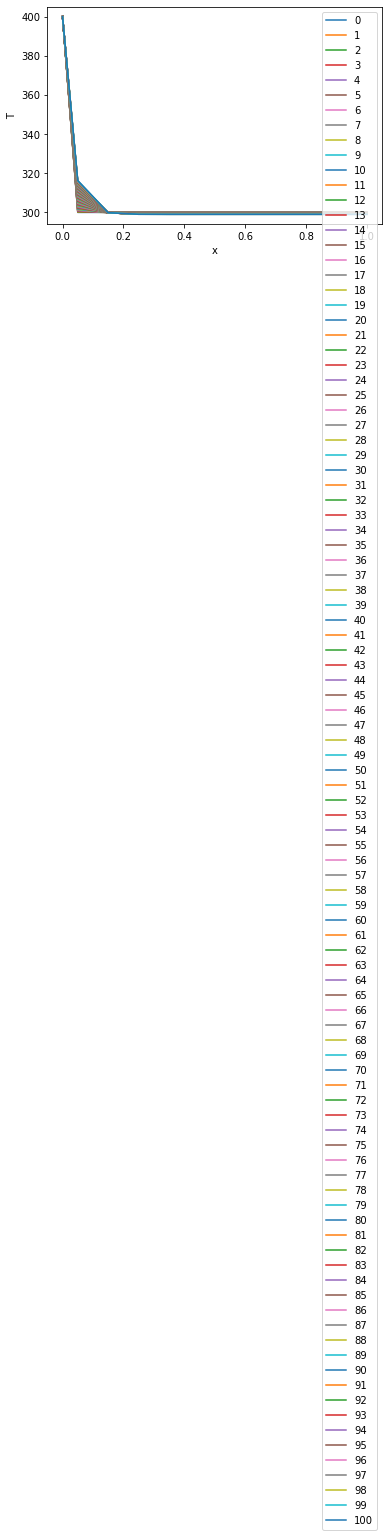

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()